In [299]:
import sys, os, io, json, numpy as np, random, time
#from sklearn.metrics import roc_auc_score
import xgboost as xgb
import tensorflow as tf
from importlib import reload
import split
reload(split)
from split import split_graph, split_interface, make_split, make_split_quick, make_gax, split_quick_graph, split_quick_graph_transpose
import graphviz
from sklearn import metrics
import cProfile


def profile(func):
    """Decorator for run function profile"""
    def wrapper(*args, **kwargs):
        profile_filename = func.__name__ + '.prof'
        profiler = cProfile.Profile()
        result = profiler.runcall(func, *args, **kwargs)
        profiler.dump_stats(profile_filename)
        return result
    return wrapper

In [300]:
pool = np.load('../prepare_dataset/pool_00.npz')
features_bool, f_time, label_orig = (pool[name] for name in ['features', 'f_time', 'label'])
label = label_orig

In [301]:
np.random.seed(42)
features = np.random.normal(loc=features_bool*1.0, scale=1.0)
#features = features[:150000,:]; label = label_orig[:150000, :]
features_swap = np.concatenate([features[:,7:8], features[:,1:7], features[:,0:1], features[:,8:]], axis=1)

In [302]:
%%time
make_split(np.zeros(label.shape), features, label)

CPU times: user 117 ms, sys: 48.6 ms, total: 165 ms
Wall time: 246 ms


{'avg_current_loss': 0.6931471805599448,
 'best_avg_loss': 0.6124402703897527,
 'best_delta_down': -0.8534899433501377,
 'best_delta_up': -0.7958979221951163,
 'best_feature_index': 11,
 'best_index': 261521,
 'best_loss': 183732.0811169258,
 'current_loss': 207944.15416798345,
 'thr': 1.3039966661872284}

In [303]:
%%time
make_split(np.zeros(label.shape), features_swap, label)

CPU times: user 129 ms, sys: 4.32 ms, total: 133 ms
Wall time: 213 ms


{'avg_current_loss': 0.6931471805599448,
 'best_avg_loss': 0.6124402703897527,
 'best_delta_down': -0.8534899433501377,
 'best_delta_up': -0.7958979221951163,
 'best_feature_index': 11,
 'best_index': 261521,
 'best_loss': 183732.0811169258,
 'current_loss': 207944.15416798345,
 'thr': 1.3039966661872284}

In [304]:
class EMatrix:
    def __init__(self, features, label, bias=None, gax=None, splitgax = False):
        self.bias = bias
        self.features = features
        self.label = label
        self.gax = gax
        self.splitgax = splitgax

In [305]:
class LeafData:
    def __init__(self, info):
        self.val = info['prediction'] * info['learning_rate']
        self.train_size = info['ematrix'].label.shape[0]
        self.avg_target = np.mean(info['ematrix'].label, axis=0)[0]
        
    def to_text(self, floatformat = '.6f'):
        return ('{:'+ floatformat + '} ({})\n({:'+floatformat+'})').format(self.val, self.train_size, self.avg_target)
    
    def shape(self):
        return 'box'

class SplitData:
    def __init__(self, val):
        self.val = val
        
    def to_text(self, floatformat = '.4f'):
        return ('f_{{{ind}}} < {thr:'+floatformat+'}').format(ind=self.val['best_feature_index'], thr=self.val['thr'])
    
        
class TreeNode:
    def __init__(self):
        self.left = None
        self.right = None
        self.depth = 0
        self.val = None
        self.id = None
        
    def to_text(self, floatformat = '.6f'):
        return self.val.to_text(floatformat)
    
    def shape(self):
        return 'circle'
        

In [306]:
def init_id_helper(node, current_id):
    node.id = current_id[0]
    current_id[0] += 1
    if not isinstance(node, TreeNode):
        return
    init_id_helper(node.left, current_id)
    init_id_helper(node.right, current_id)

def init_id(root):
    current_id = [0]
    init_id_helper(root, current_id)
    return current_id[0]

In [307]:
def init_arrays_helper(node, arrays):
    if not isinstance(node, TreeNode):
        arrays['is_leaf'][node.id] = 1
        arrays['leaf_data'][node.id, 0] = node.val  # Leaf
        return
    init_arrays_helper(node.left, arrays)
    init_arrays_helper(node.right, arrays)
    arrays['yes_node'][node.id] = node.left.id
    arrays['no_node'][node.id] = node.right.id
    arrays['thresholds'][node.id] = node.val.val['thr']
    arrays['features'][node.id] = node.val.val['best_feature_index']
    arrays['is_leaf'][node.id] = 0
    arrays['depths'][node.id] = node.depth
    
def init_arrays(root, n):
    def empty_array():
        return np.zeros(n, dtype=np.int32)
    arrays = dict(features=empty_array(),
                  thresholds=np.zeros(n, dtype=np.float32),
                  yes_node=empty_array(),
                  no_node=empty_array(),
                  is_leaf=empty_array(),
                  depths=empty_array(),
                  leaf_data=np.zeros((n,1), dtype=np.float32)
                 )
    init_arrays_helper(root, arrays)
    arrays['treedepth'] = np.max(arrays['depths'])
    return arrays

In [308]:
def prior_finish(params, info, parent):
    if parent is None:
        return False
    return params['max_depth'] <= parent.depth

def post_finish(params, info, split_info, parent):
    if split_info['left_info']['ematrix'].label.shape[0] < 2:
        return True
    if split_info['right_info']['ematrix'].label.shape[0] < 2:
        return True
    return False

In [309]:
def new_ax(ax, cond):
    reindex = np.cumsum(cond)-1
    axT = ax.T
    return reindex[axT][cond[axT]].reshape((ax.shape[1], -1)).T
time1 = 0
time2 = 0
time3 = []
def split_ematrix(ematrix, depth, transposed_feature=False, sess=None):
    global time1, time2, time3
    if ematrix.gax is not None:
        start = time.clock()
        #print(ematrix.features.shape, file=sys.stderr)
        #if (ematrix.features.shape[0]<=2):
        #    print(ematrix.gax, file=sys.stderr)
        split_info = make_split_quick(ematrix.bias, ematrix.features, ematrix.label, ematrix.gax, 
                                      transposed_feature=transposed_feature,
                                      profile_file = ('profile_cumsum3.json' if depth==1 else None), sess=sess)
        dif = time.clock() - start
        time1 += dif
        time3 += [dif]
        
        cond_left = split_info['left_cond']
        cond_right = split_info['right_cond']
        ax_left = split_info['ax_left']
        ax_right = split_info['ax_right']
    else:
        split_info = make_split(ematrix.bias, ematrix.features, ematrix.label)
        cond_left = best_feature < split_info['thr']
        cond_right = np.logical_not(cond_left)
        ax_left = ax_right = None

        
    start = time.clock()
    features = ematrix.features
    bias = ematrix.bias
    label = ematrix.label
        
    if False:
        thr = split_info['thr']        

        best_feature = features[:, split_info['best_feature_index']] 

        cond_left = best_feature < thr
        if not np.all((cond_left == split_info['left_cond']).ravel()):
                print("AAAA", file=sys.stderr)
        cond_right = np.logical_not(cond_left)
        if ematrix.gax is not None:
            ax_left = new_ax(ematrix.gax, cond_left)
            ax_right = new_ax(ematrix.gax, cond_right)
            if not np.all((ax_left == split_info['ax_left']).ravel()):
                print("AAAA", file=sys.stderr)
            if not np.all((ax_right == split_info['ax_right']).ravel()):
                print("BBBB", file=sys.stderr)
        else:
            ax_left = ax_right = None
    
    
    left_ematrix = EMatrix(features[:, cond_left] if transposed_feature else features[cond_left, :], label[cond_left], bias[cond_left], gax=ax_left)
    right_ematrix = EMatrix(features[:, cond_right] if transposed_feature else features[cond_right, :], label[cond_right], bias[cond_right], gax=ax_right)
    left_info = {'prediction': split_info['best_delta_up'], 'ematrix': left_ematrix, 'sess': sess}
    right_info = {'prediction': split_info['best_delta_down'], 'ematrix': right_ematrix, 'sess': sess}
    split_info['left_info'] = left_info
    split_info['right_info'] = right_info
    time2 += time.clock() - start
    return left_info, right_info, split_info

In [310]:
def build_tree_helper(params, info, parent):
    info['learning_rate'] = params['learning_rate']
    if parent and parent.depth < 6:
        print("{d}".format(d=parent.depth) 
              if parent else '---',
              "".format(shape=info['ematrix'].label.shape[0]),
              end=' ', file=sys.stderr)
    if prior_finish(params, info, parent):
        return LeafData(info)
    node = TreeNode()
    node.depth = parent.depth + 1 if parent else 1
    
    left_info, right_info, split_info = split_ematrix(info['ematrix'], node.depth, transposed_feature=params['transposed_feature'], sess=info['sess'])
    if post_finish(params, info, split_info, parent):
        #print(split_info['right_info']['ematrix'].label.shape[0])
        #print(split_info)
        return LeafData(info)

    node.val = SplitData(split_info)
    node.left = build_tree_helper(params, left_info, node)
    node.right = build_tree_helper(params, right_info, node)  
    return node

In [311]:
@profile
def build_tree(params, ematrix, sess = None):
    info = {'ematrix': ematrix, 'sess': sess}
    if ematrix.splitgax and ematrix.gax is None:
        ematrix.gax = make_gax(ematrix.features, axis=(1 if params['transposed_feature'] else 0))
    return build_tree_helper(params, info=info, parent=None)

In [312]:
def tree_apply(tree_arrays, features):
    qi = np.zeros(features.shape[0], dtype=np.int32)
    for current_depth in range(tree_arrays['treedepth']):
        fi = tree_arrays['features'][qi]
        f = np.choose(fi, features.T)
        t = tree_arrays['thresholds'][qi]
        #print(qi, fi, f, t)
        #if current_depth == 0: 
        #    print(fi, f.shape, features.shape, f)
        answer = (f < t)*1
        new_qi = answer*tree_arrays['yes_node'][qi] + (1-answer)*tree_arrays['no_node'][qi]
        qi = new_qi
    leaf_data = tree_arrays['leaf_data'][qi, 0]
    return leaf_data

In [313]:
features.shape, label.shape

((300000, 15), (300000, 1))

In [314]:
global_ax = make_gax(features)
featuresT = features.T
global_axT = global_ax.T

In [315]:
%%time
start_params = {'max_depth': 8, 'learning_rate':0.3, 'transposed_feature': 1}
tf.constant
time1 = time2 =0
time3 = []
with tf.Session(graph=split_quick_graph_transpose if start_params['transposed_feature'] else split_quick_graph) as s:
    tree = build_tree(start_params, EMatrix(featuresT if start_params['transposed_feature'] else features, 
                                            label, np.zeros(label.shape), 
                                            gax=global_axT if start_params['transposed_feature'] else global_ax, 
                                            splitgax=True), sess=s)
print("\nsplit time = {:.5f}, {:.5f}, [{}]".format(time1, time2, ", ".join("{:.5f}".format(tt) for tt in time3)), file=sys.stderr)
tree_arrays = init_arrays(tree, init_id(tree))

1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  4  4  5  

CPU times: user 7.26 s, sys: 402 ms, total: 7.66 s
Wall time: 2.98 s


5  2  3  3  4  5  5  4  
split time = 7.44090, 0.18473, [0.83040, 0.45775, 0.29444, 0.23496, 0.16507, 0.17985, 0.17044, 0.04012, 0.12397, 0.04305, 0.02611, 0.02895, 0.01926, 0.01387, 0.01458, 0.01402, 0.01825, 0.01563, 0.01584, 0.08204, 0.08108, 0.05030, 0.04941, 0.01770, 0.03590, 0.01541, 0.03795, 0.01922, 0.01784, 0.01441, 0.01817, 0.01465, 0.01487, 0.01537, 0.10546, 0.09498, 0.06436, 0.06030, 0.05667, 0.02145, 0.01719, 0.01617, 0.01249, 0.04430, 0.01594, 0.01490, 0.01479, 0.04757, 0.04155, 0.01605, 0.02355, 0.02060, 0.01792, 0.01654, 0.01995, 0.01533, 0.01516, 0.01595, 0.02030, 0.01441, 0.01289, 0.01367, 0.01608, 0.01558, 0.01745, 0.22554, 0.21348, 0.01566, 0.01267, 0.01188, 0.01187, 0.01397, 0.01516, 0.01410, 0.01484, 0.02094, 0.01747, 0.01820, 0.01892, 0.01527, 0.01614, 0.01570, 0.19609, 0.13593, 0.14096, 0.12277, 0.02590, 0.01468, 0.01346, 0.01391, 0.07859, 0.07849, 0.05820, 0.03047, 0.01804, 0.01601, 0.01499, 0.02043, 0.01746, 0.01655, 0.01534, 0.01430, 0.01423, 0.01628, 0.01494

In [316]:
import pstats
p = pstats.Stats('build_tree.prof')
#p.sort_stats('tottime').print_stats()

In [317]:
pred = tree_apply(tree_arrays, features)
auc1 = metrics.roc_auc_score(label[:, 0], pred)
auc0 = metrics.roc_auc_score(label[:, 0], np.zeros(label.shape[0]))
auc1, auc0

(0.5296545537774653, 0.5)

In [318]:
#tree.left.left.left.left.val, tree.val
tree.left.left

In [319]:
def tree2gv(tree):
    result = graphviz.Graph('ni')
    #result.attr(size='12,0')
    tree2gv_helper(tree, result, '')
    return result

In [320]:
def tree2gv_helper(node, result, id):
    idn = id
    result.node(idn, node.to_text(), shape='box') # node.shape())
    if isinstance(node, LeafData):
        return
    if node.left is not None:
        idl = id + '0'
        tree2gv_helper(node.left, result, idl)
        result.edge(idn, idl)
    if node.right is not None:
        idr = id + '1'
        tree2gv_helper(node.right, result, idr)
        result.edge(idn, idr)
    
    

In [321]:
#tree2gv(tree)

In [322]:
class EBooster:
    def __init__(self, forest):
        self.forest = forest
    
    def predict(self, features, tree_limit = None):
        pred = np.zeros(features.shape[0], dtype=np.float32)
        for tree, tree_arrays in (self.forest if tree_limit is None else self.forest[:tree_limit]):
            pred = pred + tree_apply(tree_arrays, features)
        return pred 
    
def train(params, ematrix, num_boost_round = 10):
    start_params = {'max_depth': 5, 'learning_rate': 0.3, 'splitgax': False, 'transposed_feature': False} 
    start_params.update(params)
    
    if start_params['splitgax'] and ematrix.gax is None:
        ematrix.gax = make_gax(ematrix.features, axis=1 if start_params['transposed_feature'] else 0)
    
    forest = []
    bias = np.zeros(ematrix.label.shape)
    with tf.Session(graph=split_quick_graph_transpose if start_params['transposed_feature'] else split_quick_graph) as s:
        for r in range(num_boost_round):
            print("\n{} round".format(r), file=sys.stderr)
            tree = build_tree(start_params, EMatrix(ematrix.features, ematrix.label, bias, gax=ematrix.gax, splitgax=start_params['splitgax']), sess=s)
            #print("tree ok, bias shape = {}".format(bias.shape), file=sys.stderr)
            tree_arrays = init_arrays(tree, init_id(tree))
            bias_delta = tree_apply(tree_arrays, features)
            #print("apply ok, bias delta shape = {}".format(bias_delta.shape), file=sys.stderr)
            bias = bias + np.reshape(bias_delta, newshape=bias.shape)
            forest.append((tree, tree_arrays))
            #print("forest appended", file=sys.stderr)
        
    return EBooster(forest)

In [324]:
%%time
boost_params = {'max_depth': 8, 'learning_rate':0.3, 'splitgax': True, 'transposed_feature': 0}
booster = train(boost_params, EMatrix(featuresT if boost_params['transposed_feature'] else features, label), num_boost_round=12)


0 round
1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  4  4  5  5  2  3  3  4  5  5  4  
1 round
1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  3  4  5  5  4  5  5  
2 round
1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  
3 round
1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  
4 round
1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  
5 round
1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4

CPU times: user 1min 28s, sys: 7.72 s, total: 1min 35s
Wall time: 39.1 s


In [297]:
#%%time
#gax13 = make_gax(features)
#print(gax13.shape)

In [298]:
pred2 = booster.predict(features)
metrics.roc_auc_score(label[:, 0], pred2)

0.5967673817001127

In [37]:
pred2b = booster.predict(features, tree_limit=16)
metrics.roc_auc_score(label[:, 0], pred2)

0.5819374042395917

In [38]:
np.min(pred2b), np.max(pred2b)

(-2.298354, 1.6780939)

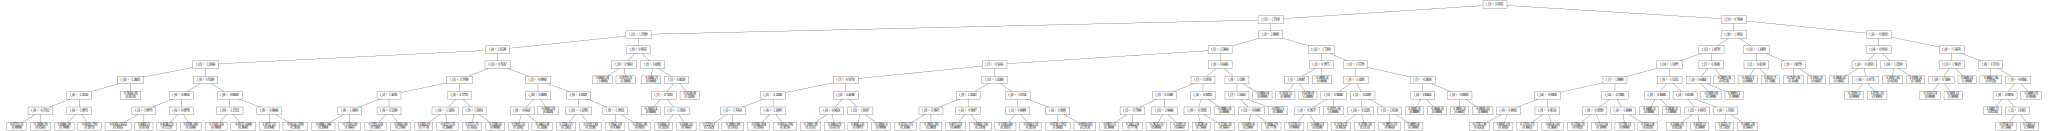

In [39]:
tree2gv(booster.forest[8][0])

In [40]:
dmat = xgb.DMatrix(features, label)

In [42]:
%%time
params = {'max_depth': 8, 'objective': 'binary:logistic', 'eta': 0.3, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=20)

[20:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[20:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[20:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=8
[20:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[20:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=8
[20:13:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[20:13:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[20:13:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[20:13:5

In [43]:
pred_fast = model.predict(dmat)
metrics.roc_auc_score(label[:, 0], pred_fast)

0.6229578176481919

In [44]:
pred_fast = model.predict(dmat, ntree_limit=16)
metrics.roc_auc_score(label[:, 0], pred_fast)

0.6160652786598844

In [ ]:
qq = -np.log(1/pred_fast-1) 
np.min(qq), np.max(qq)

In [ ]:
diff = np.abs(qq - pred2b)
np.mean(diff > 0.1)

In [ ]:
model.dump_model('xgb.dump')

In [ ]:
tree2gv(booster.forest[15][0])

In [ ]:
!cat xgb.dump | tail -n+$(echo 32*11+22 | bc)